Notebook summary: takes images taken from planet with a folder of tiff files and then converts them into pickle files that will be accepted into the dataset classes

In [22]:
%load_ext autoreload
%autoreload 2
from PIL import Image
import rasterio
from rasterio.plot import show
import numpy as np
import pickle
import glob
import re
import torch
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
image_dir = '../../../notebooks/home/data/raw/planet_images_ia-2020/'
save_prefix = '../../../../../datadrive/data/raw/ground_truth/'
mask_dir = '../../../notebooks/home/data/processed/planet_images_ia-2020/image_masks.pkl'
with open(mask_dir, 'rb') as f:
    masks = pickle.load(f)

In [3]:
mask_dirlist = list(masks.keys())

In [23]:
# Grab 1000 images for now, add more if necessary
mask_subdirlist = mask_dirlist[0:2000]

In [24]:
mask_subdirlist

['/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_6835-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_5646-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_6076-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_11752-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_7278-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_8800-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_2056-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_9083-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_12225-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2

So this block of code is the bulk of the notebook, where it loads the tiff files using the rasterio package, and then saves it to a pickle file

In [25]:
for file in mask_subdirlist:
    image_name = re.search(r'(?<=planet_images_ia-2020/)[A-z0-9\-]+', file).group()
    
    with rasterio.open(image_dir + image_name + ".tif") as src:
        b, g, r, n = src.read()
    rgb = np.stack((r,g,b), axis=0)
    
    if np.prod(rgb[0].shape) < 400*400: # this line is because there are files where some images are 342x1600000+
        np_image = (np.rollaxis(rgb/rgb.max(), 0, 3)*255).astype(np.uint8)
        image = Image.fromarray((np.rollaxis(rgb/rgb.max(), 0, 3)*255).astype(np.uint8))
        mask = masks[file]

        toSave = {}
        toSave['image'] = image
        toSave['masks'] = {}
        toSave['masks']['CAFO Shed'] = (mask == 1).astype(np.uint8).squeeze(0)
        toSave['masks']['BACKGROUND'] = (mask == 0).astype(np.uint8).squeeze(0)
        toSave['masks']['Lagoon'] = np.zeros(mask.shape).squeeze(0)
        
        with open(save_prefix + image_name + ".p", "wb") as f:
            pickle.dump(toSave, f)    

In [21]:
save_prefix+image_name

'../../../../../datadrive/data/raw/ground_truth/planet_loc_10414-date_2020-07-01'

# Checking if masks match with image

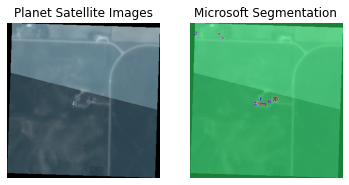

In [18]:
i = 900 # which image to check
file = mask_subdirlist[i]
image_name = re.search(r'(?<=planet_images_ia-2020/)[A-z0-9\-]+', file).group()
with rasterio.open(image_dir + image_name + ".tif") as src:
    b, g, r, n = src.read()
        
rgb = np.stack((r,g,b), axis=0)
if np.prod(rgb[0].shape) < 400*400:    
    np_image = (np.rollaxis(rgb/rgb.max(), 0, 3)*255).astype(np.uint8)
    image = Image.fromarray((np.rollaxis(rgb/rgb.max(), 0, 3)*255).astype(np.uint8))
    mask = masks[file]

    toSave = {}
    toSave['image'] = image
    toSave['masks'] = {}
    toSave['masks']['CAFO Shed'] = (mask == 1).astype(np.uint8)
    toSave['masks']['BACKGROUND'] = (mask == 0).astype(np.uint8)
    toSave['masks']['Lagoon'] = np.zeros(mask.shape)
        

    lagoon = torch.zeros(mask.shape).squeeze(0)
    cafo = torch.Tensor((mask == 1).astype(np.uint8)).squeeze(0)
    background = torch.Tensor((mask == 0).astype(np.uint8)).squeeze(0)

    labels = torch.stack([lagoon, cafo, background])

    f = plt.figure()
    a1 = f.add_subplot(1, 2, 1)
    plt.imshow(np_image)
    plt.axis('off')
    a1.title.set_text('Planet Satellite Images')
    a2 = f.add_subplot(1, 2, 2)
    plt.imshow(np_image)
    kwarg_dict = {'CAFO Shed': {'cmap':'prism', 'alpha': 0.3},
                  'Lagoon': {'cmap':'cool', 'alpha': 0.3},
                  'BACKGROUND': {'cmap':'hot', 'alpha': 0.0}}
    plt.imshow(labels[0], **kwarg_dict['BACKGROUND'])
    plt.imshow(labels[1], **kwarg_dict['Lagoon'])
    plt.imshow(labels[2], **kwarg_dict['CAFO Shed'])
    a2.title.set_text('Microsoft Segmentation')
    plt.axis('off')
    plt.show()